In [1]:
# Cell 1: Imports and Data Loading
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from hyperparameter_tuning import get_param_grids, tune_hyperparameters

# Load data
data = pd.read_csv('augmented_bakery_data.csv')

# Encode Product Type
le_product = LabelEncoder()
data['Product_Type_encoded'] = le_product.fit_transform(data['Product_Type'])

# One-hot encode Storage Conditions
storage_dummies = pd.get_dummies(data['Storage_Condition'], prefix='storage')
data = pd.concat([data, storage_dummies], axis=1)

print("Product Type Encoding:")
for i, label in enumerate(le_product.classes_):
    print(f"{label}: {i}")

print("\nStorage Condition Columns:")
print(storage_dummies.columns.tolist())


Product Type Encoding:
Bread: 0
Cookies: 1

Storage Condition Columns:
['storage_Humid', 'storage_Open', 'storage_Wrapped']


In [2]:
# Cell 2: Data Preparation Function
def prepare_data(data, target_type='product', include_other_label=False):
    """Prepare data for classification"""
    # Get base features (gains and phases)
    feature_cols = [col for col in data.columns if col.startswith(('gain_', 'phase_'))]
    X = data[feature_cols].copy()
    
    if include_other_label:
        if target_type == 'product':
            # Add one-hot encoded storage conditions
            storage_cols = [col for col in data.columns if col.startswith('storage_')]
            X = pd.concat([X, data[storage_cols]], axis=1)
        else:
            # Add product type
            X['product_type'] = data['Product_Type_encoded']
    
    # Select target
    if target_type == 'product':
        y = data['Product_Type_encoded']
    else:
        y = data['Storage_Condition']
    
    return X, y

In [3]:
# Cell 3: Model Evaluation Function
def evaluate_model(X, y, model, model_name, scaler=None):
    """Evaluate model using 10-fold cross-validation"""
    if scaler is None:
        scaler = StandardScaler()
    
    # Initialize 10-fold cross validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Lists to store fold results
    fold_accuracies = []
    all_y_true = []
    all_y_pred = []
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Scale features
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Train and predict
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        
        # Store results
        fold_accuracies.append(np.mean(y_pred == y_val))
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
    
    # Calculate overall metrics
    results = {
        'fold_accuracies': fold_accuracies,
        'mean_accuracy': np.mean(fold_accuracies),
        'std_accuracy': np.std(fold_accuracies),
        'classification_report': classification_report(all_y_true, all_y_pred),
        'confusion_matrix': confusion_matrix(all_y_true, all_y_pred)
    }
    
    return results

In [4]:
# Cell 4: Visualization Functions
def plot_confusion_matrix(cm, classes, title):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_cv_results(results, title):
    """Plot cross-validation results"""
    models = list(results.keys())
    means = [results[model]['mean_accuracy'] for model in models]
    stds = [results[model]['std_accuracy'] for model in models]
    
    plt.figure(figsize=(10, 6))
    plt.bar(models, means, yerr=stds, capsize=5)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Running experiment: product without additional features

Tuning and evaluating SVM...
Fitting 10 folds for each of 32 candidates, totalling 320 fits


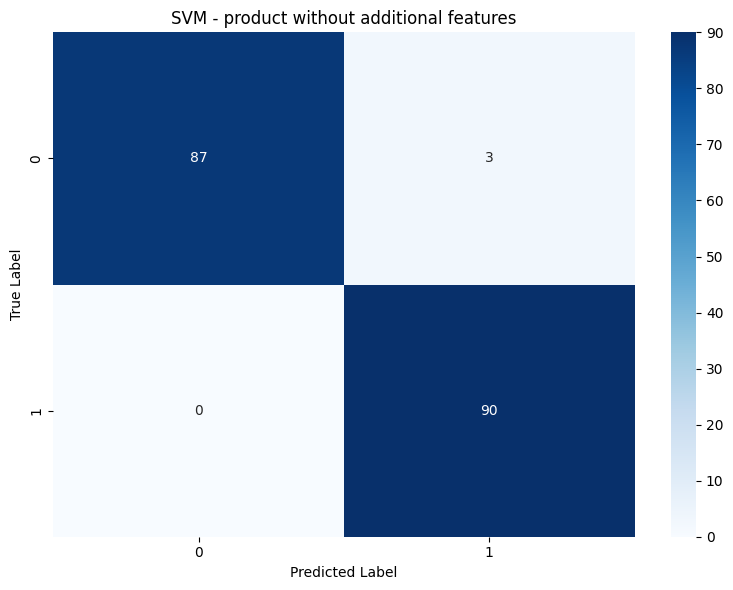


Tuning and evaluating Random Forest...
Fitting 10 folds for each of 108 candidates, totalling 1080 fits


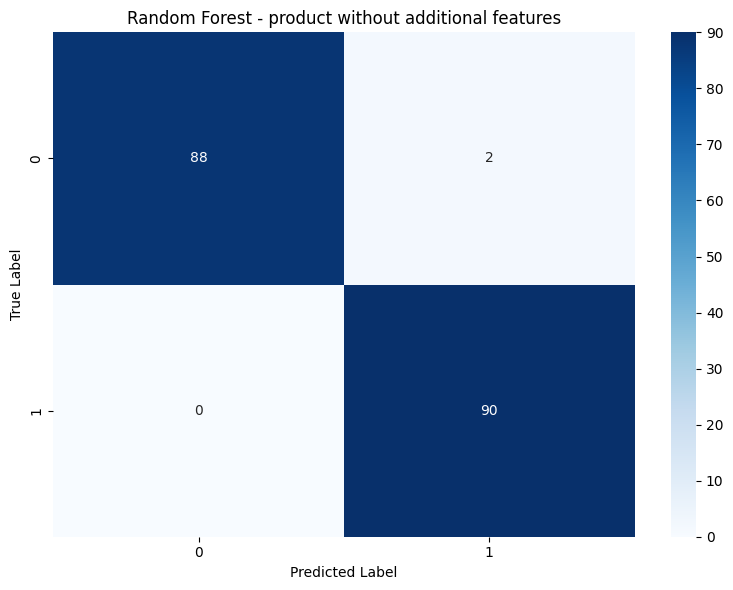


Tuning and evaluating KNN...
Fitting 10 folds for each of 16 candidates, totalling 160 fits


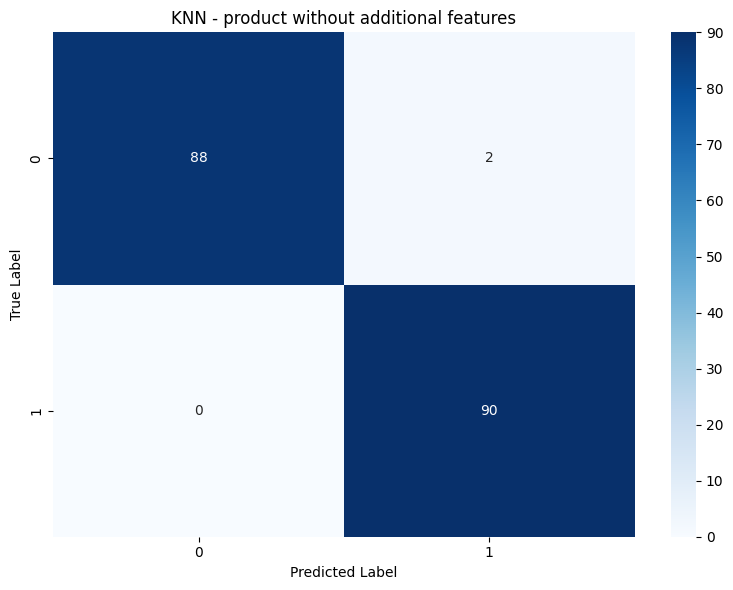


Tuning and evaluating Neural Network...
Fitting 10 folds for each of 48 candidates, totalling 480 fits


In [ ]:
# Cell 5: Run Experiments
def run_classification_experiments(data, target_type):
    experiments = [
        {'name': f'{target_type} without additional features', 'include_other_label': False},
        {'name': f'{target_type} with additional features', 'include_other_label': True}
    ]
    
    param_grids = get_param_grids()
    all_results = {}
    
    for experiment in experiments:
        print(f"\nRunning experiment: {experiment['name']}")
        X, y = prepare_data(data, target_type, experiment['include_other_label'])
        
        experiment_results = {}
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        for model_name, param_grid in param_grids.items():
            print(f"\nTuning and evaluating {model_name}...")
            
            # Tune hyperparameters
            tuning_results = tune_hyperparameters(X_scaled, y, model_name, param_grid)
            best_model = tuning_results['best_model']
            
            # Evaluate model
            eval_results = evaluate_model(X, y, best_model, model_name, scaler)
            
            # Store results
            experiment_results[model_name] = {
                'best_params': tuning_results['best_params'],
                **eval_results
            }
            
            # Plot confusion matrix
            plot_confusion_matrix(
                eval_results['confusion_matrix'],
                classes=np.unique(y),
                title=f'{model_name} - {experiment["name"]}'
            )
        
        all_results[experiment['name']] = experiment_results
        
        # Plot cross-validation results
        plot_cv_results(experiment_results, f'Model Comparison - {experiment["name"]}')
    
    return all_results

# Run experiments
product_results = run_classification_experiments(data, 'product')
storage_results = run_classification_experiments(data, 'storage')

In [17]:
# Cell 6: Save Results
def save_results(results, filename):
    """Save detailed results to file"""
    with open(filename, 'w') as f:
        for experiment, exp_results in results.items():
            f.write(f"\n{experiment}\n")
            f.write("="*50 + "\n")
            
            for model, model_results in exp_results.items():
                f.write(f"\n{model}\n")
                f.write("-"*30 + "\n")
                f.write(f"Best parameters: {model_results['best_params']}\n")
                f.write(f"Cross-validation accuracies: {model_results['fold_accuracies']}\n")
                f.write(f"Mean accuracy: {model_results['mean_accuracy']:.4f} "
                       f"(±{model_results['std_accuracy']:.4f})\n")
                f.write("\nClassification Report:\n")
                f.write(model_results['classification_report'])
                f.write("\n")

# Save results
save_results(product_results, 'product_classification_results.txt')
save_results(storage_results, 'storage_classification_results.txt')